# Setup

In [2]:
import numpy as np
import pandas as pd
import json, os
from pathlib import Path
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Data Fetching

In [3]:
!git clone https://github.com/allenai/PeerRead.git

Cloning into 'PeerRead'...
remote: Enumerating objects: 27026, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 27026 (delta 0), reused 0 (delta 0), pack-reused 27023
Receiving objects: 100% (27026/27026), 1.15 GiB | 25.38 MiB/s, done.
Resolving deltas: 100% (1466/1466), done.
Checking out files: 100% (25772/25772), done.


# Data Processing

In [4]:
def get_all_json(path):
  dev_parsed = {}
  dev_reviews = {}
  test_parsed = {}
  test_reviews = {}
  train_parsed = {}
  train_reviews = {}
  for subdir, dirs, files in os.walk(path):
    for f in files:
      path_name = os.path.join(subdir, f)
      id = '.'.join([part for part in path_name.split('/')[-1].split('.') if part.isnumeric()])
      if path_name.endswith('.pdf.json'):
        if 'dev' in path_name:
          dev_parsed[id] = json.load(open(path_name, 'r'))
        elif 'test' in path_name:
          test_parsed[id] = json.load(open(path_name, 'r'))
        elif 'train' in path_name:
          train_parsed[id] = json.load(open(path_name, 'r'))
      elif path_name.endswith('.json'):
        if 'dev' in path_name:
          dev_reviews[id] = json.load(open(path_name, 'r'))
        elif 'test' in path_name:
          test_reviews[id] = json.load(open(path_name, 'r'))
        elif 'train' in path_name:
          train_reviews[id] = json.load(open(path_name, 'r'))
  return dev_parsed, dev_reviews, test_parsed, test_reviews, train_parsed, train_reviews



paths = {
  'acl': 'PeerRead/data/acl_2017',
  'cs_ai': 'PeerRead/data/arxiv.cs.ai_2007-2017',
  'cs_cl': 'PeerRead/data/arxiv.cs.cl_2007-2017',
  'cs_lg': 'PeerRead/data/arxiv.cs.lg_2007-2017',
  'conll': 'PeerRead/data/conll_2016',
  'iclr': 'PeerRead/data/iclr_2017',
  'nips': 'PeerRead/data/nips_2013-2017'
}
acl_data = get_all_json(paths['acl'])
cs_ai_data = get_all_json(paths['cs_ai'])
cs_cl_data = get_all_json(paths['cs_cl'])
cs_lg_data = get_all_json(paths['cs_lg'])
conll_data = get_all_json(paths['conll'])
iclr_data = get_all_json(paths['iclr'])
nips_data = get_all_json(paths['nips'])

# Creating the DataFrames

In [45]:
def create_dataframe(json_data, json_reviews, dataset_name=''):
  modified_arr = []
  for id in json_data.keys():
    fields = {'id': id}
    # fields of metadata are 'source', 'title', 'authors', 'emails', 'sections', 'references', 'referenceMentions', 'year', 'abstractText', 'creator'
    # fields of review_data are 'reviews', 'abstract', 'histories', 'id', 'title'
    metadata = json_data[id]['metadata']
    review_data = json_reviews[id]
    fields['titleLen'] = len(review_data['title'])
    authors = []
    if 'authors' in review_data.keys() and len(review_data['authors']) > 0:
      authors = review_data['authors']
    elif 'authors' in metadata.keys() and len(metadata['authors']) > 0:
      authors = metadata['authors']
    fields['numAuthors'] = len(authors)
    fields['numReferences'] = len(metadata['references'])
    fields['numCitedReferences'] = len(metadata['referenceMentions'])
    fields['numRecentReferences'] = len([reference for reference in metadata['references'] if reference['year'] == metadata['year']])
    fields['avgCitedRefLength'] = 0 if len(metadata['referenceMentions']) == 0 else np.mean([len(citedReference['context']) for citedReference in metadata['referenceMentions']])
    # to add a field to the dataframe, simply add an entry to the fields dictionary in this for loop. All data can be found in metadata and review_data, whose respective fields
    # for the acl dataset are listed above. When using a new field, ensure it works across all . If you need to access a field specific to a particular dataset, use the
    # dataset_name parameter, which will be supplied accordingly.
    fields['abstractLength'] = len(review_data['abstract']) 
    
    ### GT and subjective GT section
    ## average reviewer score (weighted by confidence)
    if(len(review_data['reviews'])>0):
        wtSumRecomm = 0
        wtSumOrig = 0
        wtSumAppro = 0
        wtSumImpact = 0
        wtSumClarity = 0
        totalWt = 0
        totalRevs = len(review_data['reviews'])
        for rev in range(totalRevs):
          currRev = review_data['reviews'][rev]
          if 'REVIEWER_CONFIDENCE' in currRev.keys():
            wt = float(currRev['REVIEWER_CONFIDENCE'])
            totalWt += wt
            if 'RECOMMENDATION' in currRev.keys():
              wtSumRecomm += wt*float(currRev['RECOMMENDATION'])
            if 'ORIGINALITY' in currRev.keys():
              wtSumOrig += wt*float(currRev['ORIGINALITY'])
            if 'APPROPRIATENESS' in currRev.keys():
              wtSumAppro += wt*float(currRev['APPROPRIATENESS'])
            if 'IMPACT' in currRev:
              wtSumImpact += wt*float(currRev['IMPACT'])
            if 'SUBSTANCE' in currRev:
              wtSumImpact += wt*float(currRev['SUBSTANCE'])
            if 'CLARITY' in currRev:      
              wtSumClarity += wt*float(currRev['CLARITY'])
        if totalWt > 0:
          fields['avgReviewerConf'] = wtSumRecomm / totalWt   ## avg reviewer score
          fields['avgOrig'] = wtSumOrig / totalWt     ## avg novelty (unique)
          fields['avgAppro'] = wtSumAppro / totalWt   ## avg domain closeness conf of reviewers
          fields['avgImpact'] = wtSumImpact / totalWt    ## avg path breaking-ness/novelty (quality)
          fields['avgClarity'] = wtSumClarity / totalWt    ## avg clarity(subjective quality of idea in a way)
    else:
        fields['avgReviewerConf'] = None
        fields['avgOrig'] = None
        fields['avgAppro'] = None
        fields['avgImpact'] = None
        fields['avgClarity'] = None
    modified_arr.append(fields)
  return pd.DataFrame(modified_arr)

def create_label_df(review_path, testing_df=None):
  review_path = review_path
  all_filename = os.listdir(review_path)
  review_json = list(filter(lambda x: Path(x).suffix == '.json', all_filename)) 
  all_id = [x[:-5] for x in review_json]
  review_path = [os.path.join(review_path, x) for x in review_json]
  accepted_lst = []
  for i, this_path in enumerate(review_path):
    with open(this_path, 'r') as file:
      this_json = json.load(file)
      paper_id = all_id[i]
      accepted = None
      if 'accepted' in this_json.keys():
        accepted = this_json['accepted']
      elif testing_df is not None:
        avg_score = testing_df.loc[testing_df['id'] == paper_id]['avgReviewerConf'].values
        if avg_score is not None:
          accepted = len(avg_score) > 0 and avg_score[0] >= 3
      accepted_lst.append(accepted)
  d = {'paper_id': all_id, 'accepted': accepted_lst}
  df = pd.DataFrame.from_dict(d)
  return df

# 637 test
# 11,090 train
parent_paths = [paths[s] for s in ['acl', 'cs_ai', 'cs_cl', 'cs_lg', 'conll', 'iclr']]
review_paths = sum([[path + '/dev/reviews', path + '/test/reviews', path + '/train/reviews'] for path in parent_paths], [])
testing_dfs = [create_dataframe(data[4], data[5], dataset_name=i) for i,data in enumerate([acl_data, cs_ai_data, cs_cl_data, cs_lg_data, conll_data, iclr_data, nips_data])]
training_dfs = [create_dataframe(data[2], data[3]) for data in [acl_data, cs_ai_data, cs_cl_data, cs_lg_data, conll_data, iclr_data, nips_data]]
label_dfs = [create_label_df(review_path,testing_df=testing_dfs[i//3]) for i, review_path in enumerate(review_paths)]
testing_dfs[1]

,id,titleLen,numAuthors,numReferences,numCitedReferences,numRecentReferences,avgCitedRefLength,abstractLength,avgReviewerConf,avgOrig,avgAppro,avgImpact,avgClarity
0,1307.4479,63,3,15,80,0,210.612500,1466,None,None,None,None,None
1,1609.00222,62,4,17,36,0,175.305556,1087,None,None,None,None,None
2,1702.02628,66,4,17,26,1,118.576923,1166,None,None,None,None,None
3,1302.6813,62,5,22,1,0,328.000000,553,None,None,None,None,None
4,1411.1507,38,3,18,32,1,119.125000,368,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3677,1212.0059,82,1,9,10,0,130.800000,817,None,None,None,None,None
3678,1203.3535,36,3,32,39,0,110.589744,1167,None,None,None,None,None
3679,1302.4953,27,3,11,1,0,88.000000,762,None,None,None,None,None
3680,1703.04070,51,3,37,26,0,577.115385,940,None,None,None,None,None


In [46]:
label_dfs[3]

,paper_id,accepted
0,1509.04904,False
1,1610.06486,False
2,1511.05749,False
3,1605.04071,False
4,1705.00047,False
...,...,...
200,1205.2637,False
201,1302.4938,False
202,1608.06845,False
203,1202.3721,False


# Running K-Means Clustering on the CS AI Dataset

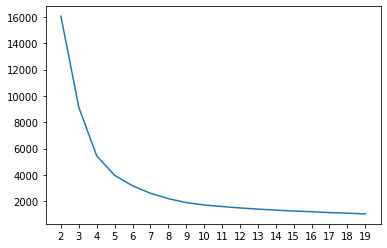

In [49]:
import itertools

numpy_arr = testing_dfs[1].values[:, 1:7]
k_values = list(range(2, 20))
losses = []
saved = None
for k in k_values:
  km = KMeans(n_clusters = k)
  km.fit(numpy_arr)
  if k == 4:
    saved = km
  distances = km.fit_transform(numpy_arr)
  losses.append(np.mean(np.min(distances, axis=1)**2))
plt.plot([str(d) for d in k_values], losses)
plt.show()

# KMeans Cluster Graphs

[3 3 3 ... 0 2 3]


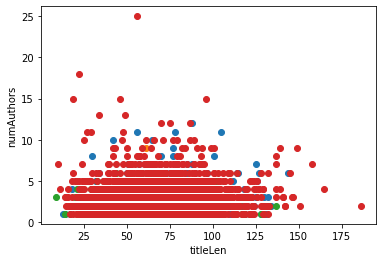

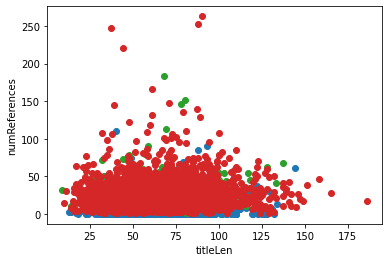

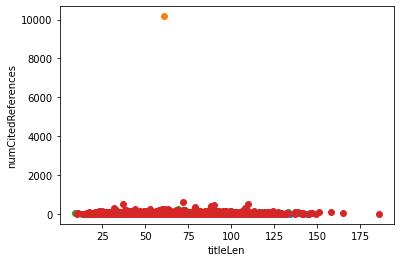

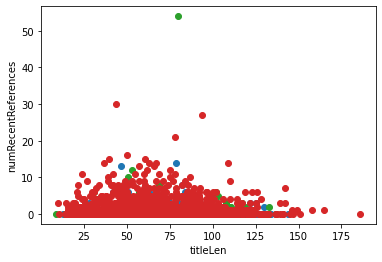

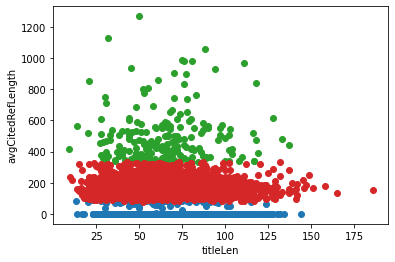

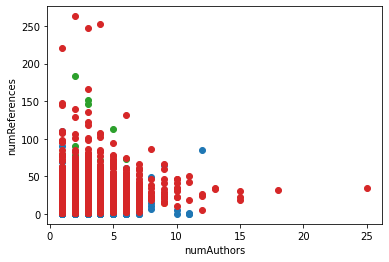

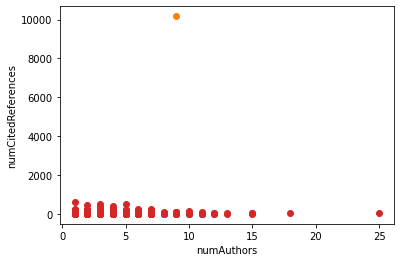

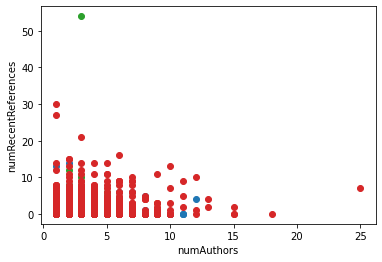

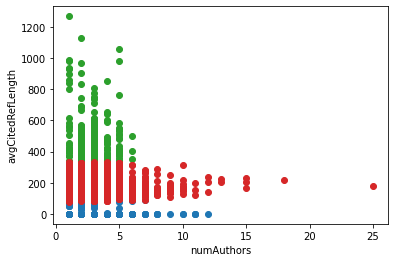

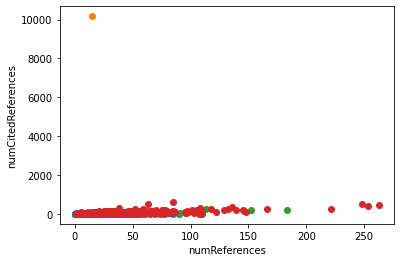

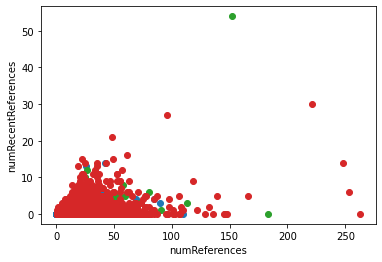

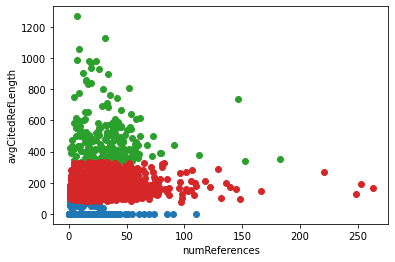

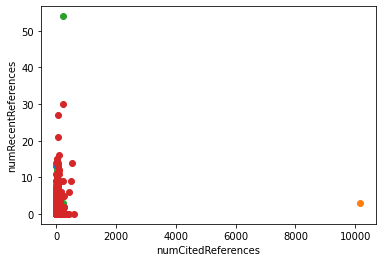

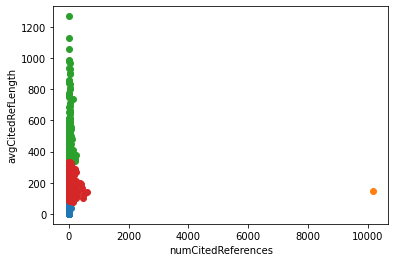

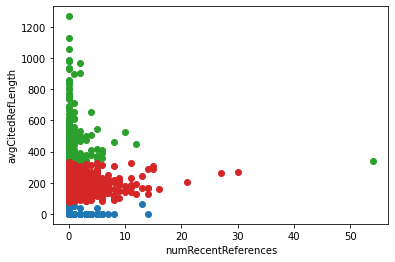

In [50]:
features = ['titleLen',	'numAuthors',	'numReferences',	'numCitedReferences',	'numRecentReferences',	'avgCitedRefLength']
print(saved.labels_)
# print(np.argwhere(np.array(saved.labels_) == 1))
for (index1, feature1), (index2, feature2) in itertools.combinations(enumerate(features), 2):
  for i in range(5):
    data_points = np.squeeze(np.argwhere(np.array(saved.labels_) == i))
    matching_coords = []
    if len(numpy_arr[data_points, :].shape) == 2:
      matching_coords = numpy_arr[data_points, :][:, [index1, index2]]
    else:
      matching_coords = np.array([[numpy_arr[data_points, :][index1], numpy_arr[data_points, :][index2]]])
    plt.scatter(matching_coords[:, 0], matching_coords[:, 1])
  plt.xlabel(feature1)
  plt.ylabel(feature2)
  plt.show()
      
